### Import Data and Necessary Packages:

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Data Set into DataFrame StudentHealth
df = pd.read_csv("Impact_of_Mobile_Phone_on_Students_Health.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Names                           100 non-null    object
 1   Age                             100 non-null    object
 2   Gender                          100 non-null    object
 3   Mobile Phone                    100 non-null    object
 4   Mobile Operating System         100 non-null    object
 5   Mobile phone use for education  98 non-null     object
 6   Mobile phone activities         99 non-null     object
 7   Helpful for studying            98 non-null     object
 8   Educational Apps                98 non-null     object
 9   Daily usages                    99 non-null     object
 10  Performance impact              98 non-null     object
 11  Usage distraction               98 non-null     object
 12  Attention span                  99 non-null     obj

### Data Preprocessing

In [4]:
# Clean column names
df.columns = df.columns.str.strip()

# Fill NaN values in 'Health rating' and combine similar classes
df['Health rating'].fillna('Good', inplace=True)
df['Health rating'] = df['Health rating'].replace({
    'Excellent;Good': 'Excellent',
    'Good;Fair': 'Good',
    'Excellent;Good;Fair;Poor': 'Excellent',
    'Poor': 'Fair',
    'Fair': 'Good'
})

# Transform 'Health precautions' into binary (Yes/No)
df['Health precautions'] = df['Health precautions'].apply(lambda x: 'Yes' if x != 'None of Above' else 'No')

# Encode categorical columns using LabelEncoder
label_encoders = {}
for column in ['Gender', 'Mobile Operating System', 'Mobile phone use for education',
               'Mobile phone activities', 'Helpful for studying', 'Educational Apps',
               'Daily usages', 'Performance impact', 'Usage distraction', 'Attention span',
               'Useful features', 'Health Risks', 'Beneficial subject', 'Usage symptoms',
               'Symptom frequency', 'Health precautions']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Select features and target
X = df[['Mobile Operating System', 'Mobile phone use for education', 'Mobile phone activities',
        'Helpful for studying', 'Daily usages', 'Health precautions']]
y = df['Health rating']

# Encode the target variable 'Health rating'
le_health_rating = LabelEncoder()
y_encoded = le_health_rating.fit_transform(y)

# Add new features
X_scaled = X.copy()
X_scaled['Mobile_OS_Education'] = X['Mobile Operating System'] * X['Mobile phone use for education']
X_scaled['Activities_Helpful'] = X['Mobile phone activities'] * X['Helpful for studying']

### Support Vector Machine Model:

In [5]:
# Define the parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3],  # Only used for 'poly' kernel
    'gamma': ['scale', 'auto']
}

# Use StratifiedKFold for cross-validation with fewer splits
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Initialize GridSearchCV for SVM with StratifiedKFold
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=stratified_kfold, scoring='accuracy')

# Fit the grid search to the data
svm_grid_search.fit(X_scaled, y_encoded)

# Get the best parameters and score
best_svm_params = svm_grid_search.best_params_
best_svm_score = svm_grid_search.best_score_

# Train the best SVM model
best_svm_model = SVC(**best_svm_params, random_state=42)
best_svm_model.fit(X_scaled, y_encoded)

# Evaluate the model
svm_accuracy = best_svm_score
print("SVM Best Parameters:", best_svm_params)
print("SVM Accuracy:", svm_accuracy)

SVM Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy: 0.66


### Decision Tree Model:

In [6]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use StratifiedKFold for cross-validation with fewer splits
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Initialize GridSearchCV for Decision Tree with StratifiedKFold
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=stratified_kfold, scoring='accuracy')

# Fit the grid search to the data
dt_grid_search.fit(X_scaled, y_encoded)

# Get the best parameters and score
best_dt_params = dt_grid_search.best_params_
best_dt_score = dt_grid_search.best_score_

# Train the best Decision Tree model
best_dt_model = DecisionTreeClassifier(**best_dt_params, random_state=42)
best_dt_model.fit(X_scaled, y_encoded)

# Evaluate the model
dt_accuracy = best_dt_score
print("Decision Tree Best Parameters:", best_dt_params)
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree Best Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Accuracy: 0.64


### Evaluation

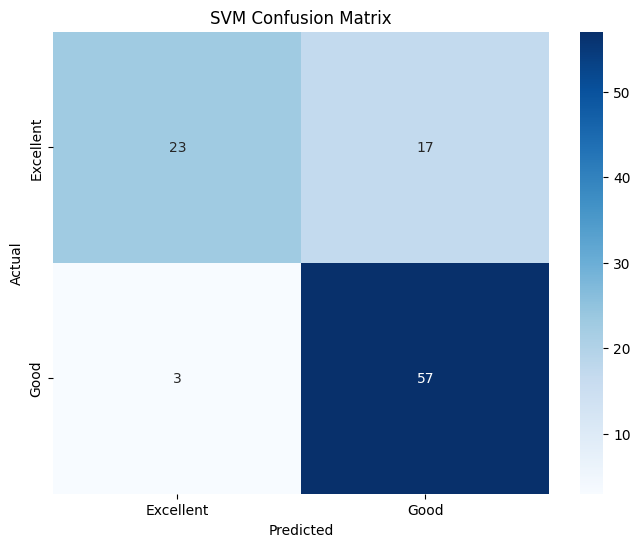

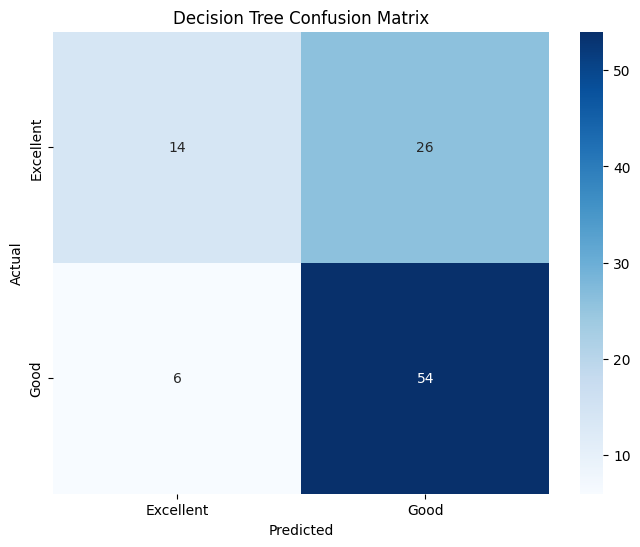

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_health_rating.classes_, yticklabels=le_health_rating.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Predict the classes using the trained models
svm_predictions = best_svm_model.predict(X_scaled)
dt_predictions = best_dt_model.predict(X_scaled)

# Compute confusion matrices for both models
svm_cm = confusion_matrix(y_encoded, svm_predictions)
dt_cm = confusion_matrix(y_encoded, dt_predictions)

# Plot confusion matrices for SVM and Decision Tree
plot_confusion_matrix(svm_cm, 'SVM Confusion Matrix')
plot_confusion_matrix(dt_cm, 'Decision Tree Confusion Matrix')

In [9]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_encoded, svm_predictions)
svm_report = classification_report(y_encoded, svm_predictions, target_names=le_health_rating.classes_)

# Evaluate the Decision Tree model
dt_accuracy = accuracy_score(y_encoded, dt_predictions)
dt_report = classification_report(y_encoded, dt_predictions, target_names=le_health_rating.classes_)

(svm_accuracy, svm_report), (dt_accuracy, dt_report)

((0.8,
  '              precision    recall  f1-score   support\n\n   Excellent       0.88      0.57      0.70        40\n        Good       0.77      0.95      0.85        60\n\n    accuracy                           0.80       100\n   macro avg       0.83      0.76      0.77       100\nweighted avg       0.82      0.80      0.79       100\n'),
 (0.68,
  '              precision    recall  f1-score   support\n\n   Excellent       0.70      0.35      0.47        40\n        Good       0.68      0.90      0.77        60\n\n    accuracy                           0.68       100\n   macro avg       0.69      0.62      0.62       100\nweighted avg       0.69      0.68      0.65       100\n'))